This notebook was done to implement the **complete Global Registration and local refinement pipeline (FPFH + RANSAC+ ICP)** on the public datasets **3DMatch and 3DLoMatch**. Overall, it follows the same implemantation as the previous notebook, but with some minor changes to adapt it to read data from the desired datasets instead of using the standard Open3D demo data. Hence, here we only highlight what have been modified in relation to the previous implemantation.

For further detail on this complete pipeline, refer to the previous notebook that presented it: https://colab.research.google.com/drive/1xVCUeVGsRn_gkDODaQX-XpvTth6RwbFS?usp=sharing

Furthermore, for details on the local refinement with ICP implementation, refer to the notebook: https://colab.research.google.com/drive/1pRmFIOI4-bQadicDb7-i8RV1blPlGxl1?usp=sharing

---

# 1 Setting Up the Environment

First, we need to install the library Open3D as well as import the others which will be used.

In [1]:
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
import open3d as o3d
import numpy as np
import pandas as pd
import urllib.request
import zipfile
import copy
import os
import shutil
from datetime import datetime
from zoneinfo import ZoneInfo

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


---

# 2 Input Data

Now, as mentioned in the beginning, we are going to use the 3DMatch dataset. More specifically, we will adopt the preprocessed by OverlapPedrato an avilable at https://share.phys.ethz.ch/~gsg/pairwise_reg/3dmatch.zip

In order to read it, first we create a folder dedicated to the data used in our tests. Then, we download the `.zip` file containing the data and unzip it into the data folder.

Besides that, for this case, we must correct the data split by creating a `validation` split as explained in the notes of this project's meetings. The scenes that should be used for validation are defined in `configs/3dmatch_val.txt`.

In [2]:
# Define folder and file path
download_folder = "../data"
file_name = "3dmatch.zip"
file_url = "https://share.phys.ethz.ch/~gsg/pairwise_reg/3dmatch.zip"
file_path = os.path.join(download_folder, file_name)

# Create folder if it doesn't exist
os.makedirs(download_folder, exist_ok=True)

# Download the file if it doesn't exist
if not os.path.exists(file_path):
    print(f"Downloading {file_name}...")
    urllib.request.urlretrieve(file_url, file_path)
    print("Download completed.")
else:
    print(f"{file_name} already exists, skipping download.")



# Unzip the file if not already extracted
temp_extract_path = os.path.join(download_folder, os.path.splitext(file_name)[0])  # "3dmatch"
final_extract_path = os.path.join(download_folder, "3DMatch")  # Renamed folder

# Extract only if "3DMatch" does not exist
if not os.path.exists(final_extract_path):
    print(f"Extracting files to {final_extract_path}...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(download_folder)             # Extract
    os.rename(temp_extract_path, final_extract_path)    # Rename
    print("Extraction complete.")

    # Create validation folder
    validation_path = os.path.join(final_extract_path, "validation")
    train_path = os.path.join(final_extract_path, "train")
    os.makedirs(validation_path, exist_ok=True)

    # Move folders from "train" to "validation"
    txt_path = "../configs/3dmatch_val.txt"
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            folders_to_move = [line.strip() for line in f.readlines()]   # .strip() removes space and \n

        for folder in folders_to_move:
            src_folder = os.path.join(train_path, folder)
            dest_folder = os.path.join(validation_path, folder)
            if os.path.exists(src_folder):
                shutil.move(src_folder, dest_folder)
                print(f"Moved {folder} to validation folder.")
            else:
                print(f"Warning: {folder} not found in train folder.")
    else:
        print(f"Warning: {txt_path} not found. No folders were move")
              
else:
    print(f"Folder '{final_extract_path}' already exists, skipping extraction.")

print("Dataset is ready!")

Download completed.
Extracting files to ../data/3DMatch...
Extraction complete.
Moved sun3d-brown_bm_4-brown_bm_4 to validation folder.
Moved sun3d-harvard_c11-hv_c11_2 to validation folder.
Moved 7-scenes-heads to validation folder.
Moved rgbd-scenes-v2-scene_10 to validation folder.
Moved bundlefusion-office0_1 to validation folder.
Moved bundlefusion-office0_2 to validation folder.
Moved bundlefusion-office0_3 to validation folder.
Moved analysis-by-synthesis-apt2-kitchen to validation folder.
Dataset is ready!


Then we can create a HashMap (dictionary) where each dataset is a key and its values are another hash map which contains the scenes of each split (train, test and validation).

By defining this, later we can read any pair of clouds using this HashMap as a directory reference.

In [3]:
data = {}                                               #HashMap of scenes for each dataset
data_root = "../data" 
datasets = ['3DMatch']      #os.listdir(data_root)                        #list of all datasets

for dataset in datasets:                                #for each dataset
    dataset_dir = os.path.join(data_root, dataset)      #get its directory
    scenes = {}                                         #initialize a hash map for its scenes

    for split in os.listdir(dataset_dir):               #for each split (train, test, val)
        split_dir = os.path.join(dataset_dir, split)    #get directory
        scenes[split] = os.listdir(split_dir)           #saves all of its scenes

    data[dataset] = scenes                              #save all splits for the dataset

print(data)

{'3DMatch': {'train': ['7-scenes-fire', 'sun3d-mit_w20_athena-sc_athena_oct_29_2012_scan1_erika_4', 'bundlefusion-apt2_2', 'sun3d-brown_bm_1-brown_bm_1_2', 'sun3d-hotel_sf-scan1_4', 'sun3d-mit_32_d507-d507_2_1', 'sun3d-hotel_sf-scan1_2', '7-scenes-chess', 'sun3d-harvard_c5-hv_c5_1', 'analysis-by-synthesis-office2-5b', 'bundlefusion-office2', 'analysis-by-synthesis-apt2-luke', 'bundlefusion-apt2_1', 'sun3d-mit_46_ted_lab1-ted_lab_2_3', 'bundlefusion-copyroom_1', 'bundlefusion-apt0_3', 'rgbd-scenes-v2-scene_12', 'sun3d-mit_32_d507-d507_2_2', 'rgbd-scenes-v2-scene_11', 'analysis-by-synthesis-apt2-bed', 'analysis-by-synthesis-office2-5a', 'bundlefusion-office1_1', 'sun3d-brown_cs_2-brown_cs2_1', 'sun3d-mit_46_ted_lab1-ted_lab_2_1', 'sun3d-mit_46_ted_lab1-ted_lab_2_2', 'sun3d-hotel_sf-scan1_1', 'sun3d-brown_cogsci_1-brown_cogsci_1', 'rgbd-scenes-v2-scene_04', 'rgbd-scenes-v2-scene_07', 'sun3d-brown_cs_2-brown_cs2_2', '7-scenes-pumpkin', 'rgbd-scenes-v2-scene_08', 'analysis-by-synthesis-apt1

We can also define a function to visualize the given data split data (pre processed by OverlapPredator and also used for GeoTransformer).

In [4]:
def get_split(data):
    """
    Prints the data split, i.e. the amount of scenes contained in
    each split (train, validation and test) of a given dataset.

    Args:
        data (dictionary): hash map of the data structured in the following way:
        {dataset: {train: [scene_list], test: [scene_list], validation: [scene_list]},
         dataset: {...},
         ...}

    Returns:
        None
    """

    for dataset in data.keys():
        print("========= %s =========" %dataset)
        print("Amount of scenes for each split:")
        print("-> Train: %d" %len(data[dataset]['train']))
        print("-> Test: %d" %len(data[dataset]['test']))
        print("-> Validation: %d" %len(data[dataset]['validation']))

get_split(data)

========= 3DMatch =========
Amount of scenes for each split:
-> Train: 74
-> Test: 8
-> Validation: 8


Once again we also define the function that allows us to visualize the relative pose between a pair of clouds.

In [5]:
def draw_registration_result(source, target, transformation, voxel_size=0.0):
    """
    Plots the pair of target (cyan) and transformed source (yellow)
    cloud on top of each other. It also performs downsampling, if
    desired, to speed up the visualization.

    Args:
        source (open3d.geometry.PointCloud): Source cloud
        target (open3d.geometry.PointCloud): Target cloud
        transformation (numpy.ndarray): Transformation to be visualized
        voxel_size (float): Resulting size of voxels after downsampling,
                            if desired (default is no downsampling)

    Returns:
        open3d.geometry.PointCloud: Downsampled cloud
        open3d.registration.Feature: Features for registration
    """

    #create copies of both clouds to protect original data
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)

    #downsample for faster visualization (voxel_size is in meters)
    if (voxel_size):
        source_temp = source_temp.voxel_down_sample(voxel_size)
        target_temp = target_temp.voxel_down_sample(voxel_size)

    #paint target cyan and source yellow
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    #apply the transformation to the source cloud
    source_temp.transform(transformation)

    #plot target and transformed source clouds
    o3d.visualization.draw_plotly([source_temp, target_temp], width=1200, height=800)

---

# 3 ICP Pipeline Implementation (Global Registration — FPFH + RANSAC — and Local Refinement — ICP)

Now, we define the same functions as before to implement the complete pipeline.

OBS: the only diference here is that for the ICP refinement, since a plane-to-plane ICP algorithm was used, we had to modify its function to estimate the normals of the target cloud. This was needed because in the preprocessing function, only the normals of the downsampled clouds are estimated, but the ICP uses the clouds at their original resolution.

In [6]:
def preprocess_cloud(pcd, voxel_size):
    """
    Performs the preprocessing of a given cloud. Thus, this function:
    downsamples, estimate the normals and extract features (through
    FPFH algorithm) of the input cloud.

    Args:
        pcd (open3d.geometry.PointCloud): Input point cloud
        voxel_size (float): Resulting size of voxels after downsampling

    Returns:
        open3d.geometry.PointCloud: Downsampled cloud
        open3d.registration.Feature: Features for registration
    """

    #downsampling
    pcd_down = pcd.voxel_down_sample(voxel_size)

    #normals estimation
    radius_normal = 2*voxel_size
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    #FPFH
    radius_feature = 5*voxel_size
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd_down, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

    return pcd_down, pcd_fpfh



def execute_GlobalRegistration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
    """
    Executes the Global Registration (through RANSAC algorithm) of
    the input source cloud (after being downsampled), given its
    FPFH features, in order to align it to the target cloud.

    Args:
        source_down (open3d.geometry.PointCloud): Downsampled source cloud
        target_down (open3d.geometry.PointCloud): Downsampled target cloud
        source_fpfh (open3d.registration.Feature): FPFH features of source cloud
        target_fpfh (open3d.registration.Feature): FPFH features of target cloud
        voxel_size (float): Resulting size of voxels after downsampling

    Returns:
        open3d.pipelines.registration.RegistrationResult: Class that contains the registration results
    """

    dist_threshold = 1.5*voxel_size

    global_registration = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
                          source_down, target_down, source_fpfh, target_fpfh,
                          True,                                                                             #mutual filter activated
                          dist_threshold,                                                                   #max_correspondence_distance
                          o3d.pipelines.registration.TransformationEstimationPointToPoint(False),           #point-to-point estimation without scaling
                          3,                                                                                #ransac_n
                          [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),          #checkers to be used
                           o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(dist_threshold)],
                          o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))              #convergence criteria

    return global_registration



def execute_ICPrefinement(source, target, dist_threshold, trans_init, voxel_size):
    """
    Executes the local ICP refinement of a initial transformation.

    Args:
        source (open3d.geometry.PointCloud): Source cloud
        target (open3d.geometry.PointCloud): Target cloud
        dist_threhsold (float): Threshold distance for a correspondence pair to be considered valid
        trans_init (numpy.ndarray): Initial transformation matrix
        voxel_size (float): Resulting size of voxels after downsampling

    Returns:
        open3d.pipelines.registration.RegistrationResult: Class that contains the registration results
    """

    #target normals estimation
    radius_normal = 2*voxel_size
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    #performs the point-to-plane ICP
    ICP_registration = o3d.pipelines.registration.registration_icp(source, target, dist_threshold, trans_init,
                                                                   o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return ICP_registration

Now we can define an overall registration function that combines all the previous ones.

In [7]:
def GlobalRegistration_withICP(source, target, voxel_size, dist_threshold_ICP):
    """
    Executes the complete pipeline of Global Registration (FPFH + RANSAC) with ICP refinement.

    Args:
        source (open3d.geometry.PointCloud): Source cloud
        target (open3d.geometry.PointCloud): Target cloud
        voxel_size (float): Resulting size of voxels after downsampling
        dist_threhsold_ICP (float): Threshold distance for a correspondence pair to be considered valid during ICP

    Returns:
        open3d.pipelines.registration.RegistrationResult: Class that contains the registration results
    """

    #Preprocessing (downsampling + FPFH feature extraction)
    source_down, source_fpfh = preprocess_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_cloud(target, voxel_size)

    #Global Alignment (RANSAC)
    result_ransac = execute_GlobalRegistration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

    #Local Refinement (ICP)
    trans_init = result_ransac.transformation
    result_icp = execute_ICPrefinement(source, target, dist_threshold_ICP, trans_init, voxel_size)

    return result_icp

Hence, we can apply it to all our data. As required by the [3DMatch](https://3dmatch.cs.princeton.edu/#geometric-registration-benchmark) dataset, in order to properly evaluate it, **for each scene, we have to extensively try to register each non-consecutive fragment pair**:
$ (P_i, P_j)_{i+1<j} $

First we define a function that performs the registration for all non-consecutive pairs of clouds from a specific scene.

Notice that here you can use a `matching_pairs` list that defines a subset of pairs to be considered for testing. This is done to allow to run faster and partial tests. Besides that, only pairs with an overlap of at least `30%` are saved, following the author's evaluation convention (i.e., an alignment is considered achieved only with it produced a registration with over 30% overlap)

In [8]:
def compute_overlap_ratio(pcd0, pcd1, trans, voxel_size):
    pcd0_down = pcd0.voxel_down_sample(voxel_size)
    pcd1_down = pcd1.voxel_down_sample(voxel_size)
    matching01 = get_matching_indices(pcd0_down, pcd1_down, trans, voxel_size, 1)
    matching10 = get_matching_indices(pcd1_down, pcd0_down, np.linalg.inv(trans),
                                    voxel_size, 1)
    overlap0 = len(matching01) / len(pcd0_down.points)
    overlap1 = len(matching10) / len(pcd1_down.points)
    return max(overlap0, overlap1)

def get_matching_indices(source, target, trans, search_voxel_size, K=None):
    source_copy = copy.deepcopy(source)
    target_copy = copy.deepcopy(target)
    source_copy.transform(trans)
    pcd_tree = o3d.geometry.KDTreeFlann(target_copy)

    match_inds = []
    for i, point in enumerate(source_copy.points):
        [_, idx, _] = pcd_tree.search_radius_vector_3d(point, search_voxel_size)
        if K is not None:
            idx = idx[:K]
        for j in idx:
            match_inds.append((i, j))
    return match_inds


def ICP_pipeline_scene(scene_dir, voxel_size, dist_threshold_ICP, subset=None, matching_pairs=None):
    """
    Executes the complete ICP pipeline for a whole scene.

    Args:
        scene_dir (string): Directory of the scene
        voxel_size (float): Resulting size of voxels after downsampling
        dist_threhsold_ICP (float): Threshold distance for a correspondence
                                     pair to be considered valid during ICP

    Returns:
        pd.DataFrame: Pandas DataFrame with the registration results of the scene
        list: Array where each element is a point cloud of the scene
    """

    scene = scene_dir.split('/')[-1]
    frag_path = os.path.join(scene_dir, 'fragments')


    if not subset:
        num_frags = len(os.listdir(frag_path))                                              #compute number of fragments
        matching_pairs = {scene: []}
        for i in range(num_frags):
            for j in range(i + 2, num_frags):
                matching_pairs[scene].append([i, j])


    #table to save registrations results of each scene
    scene_results = pd.DataFrame({
    "Scene": pd.Series(dtype='str'),
    "Target": pd.Series(dtype='int'),
    "Source": pd.Series(dtype='int'),
    "Fitness": pd.Series(dtype='float'),
    "Inlier RMSE": pd.Series(dtype='float'),
    "Transformation": pd.Series(dtype='object')
    })

    for pair in matching_pairs[scene]:

        tgt_ID, src_ID = pair[0], pair[1]
        print('\tMatching %03d %03d' %(tgt_ID,src_ID))

        src_path = os.path.join(frag_path, 'cloud_bin_%d.ply' %src_ID)
        tgt_path = os.path.join(frag_path, 'cloud_bin_%d.ply' %tgt_ID)

        source = o3d.io.read_point_cloud(src_path)
        target = o3d.io.read_point_cloud(tgt_path)

        #Execute the complete pipeline
        final_reg = GlobalRegistration_withICP(source, target, voxel_size, dist_threshold_ICP)

        ratio = compute_overlap_ratio(source, target, final_reg.transformation, voxel_size)
        print('\t\tOverlap Ratio: %.4f' %ratio)

        if ratio > 0.3:
            #Add new result in the table
            new_result = pd.DataFrame({"Scene": scene,
                                       "Target": tgt_ID,
                                       "Source": src_ID,
                                       "Fitness": final_reg.fitness,
                                       "Inlier RMSE": final_reg.inlier_rmse,
                                       "Transformation": [final_reg.transformation]})           #wrapper on matrix -> check observation below
            scene_results = pd.concat([scene_results, new_result], ignore_index=True)

    return scene_results

OBS: To save the transformation in the table, we need to use a wrapper around the numpy array, so we pass it as a list using [ ]. This is needed because Pandas expects each column/row to be a sequence of values. So, without the brackets, Pandas would try to iterate over *final_reg.transformation* and add each row of the transformation matrix as separate rows of the dataframe, which is not desired. By enclosing it in brackets, we ensure that the entire transformation matrix is inserted as a single entry in the DataFrame.

Then we can also define a function to perform the pipeline on all the scenes of a given split of a dataset.

OBS: here we use the `defaultdict(list)` just to avoid having to initialize each key. In this way, any time we add something to a key, in case that key does not exist yet, it is automatically initialized with its default value as a empty list.

As mentioned before, here you can use a `configs/matching_pairs.txt` file that defines which subset of pairs should be consider for testing. This is done to allow to run fast and partial tests. This file is generated by the FCGF algorithm, in such a way that first we perform the test on FCGF, which randomly samples non-conversutive pairs for alignment. Then, it saves the pairs it considered in a `.txt` file, which we use here to guarantee that we valuate ICP with the same samples (pairs).

In [9]:
def get_matching_pairs(file):
    scene = None
    matching_pairs = defaultdict(list)
    with open(file, 'r') as f:
        for line in f:
            line = line.replace('\n','').split()

            if line[0] == 'Set:':
                scene = line[1]
                continue
            elif scene:
                matching_pairs[scene].append([int(line[0]), int(line[1])])
    return matching_pairs


def ICP_pipeline(dataset, split, voxel_size, dist_threshold_ICP, subset=False):
    """
    Executes the complete ICP pipeline for a whole split
    (train, test or validation) of a given dataset.

    Args:
        dataset (string): Name of dataset
        split (string): Which split to be used ('train', 'validation' or 'test')
        voxel_size (float): Resulting size of voxels after downsampling
        dist_threhsold_ICP (float): Threshold distance for a correspondence
                                     pair to be considered valid during ICP

    Returns:
        pd.DataFrame: Pandas DataFrame with the registration results of the split
        collections.defaultdict: Hash map where keys are the scene's name and values are the list of all its clouds
    """

    #table to save registrations results of each scene
    dataset_results = pd.DataFrame({
    "Scene": pd.Series(dtype='str'),
    "Target": pd.Series(dtype='int'),
    "Source": pd.Series(dtype='int'),
    "Fitness": pd.Series(dtype='float'),
    "Inlier RMSE": pd.Series(dtype='float'),
    "Transformation": pd.Series(dtype='object')
    })

    if subset:
        if not os.path.isfile('../configs/matching_pairs.txt'):
            print("The file with the cloud pairs to be considered for the subset test was not found.")
        else:
            matching_pairs = get_matching_pairs('../configs/matching_pairs.txt')
    else:
        matching_pairs = None

    for scene in data[dataset][split]:                                                              #for each scene
        print("Set: %s," %scene)

        scene_dir = os.path.join(data_root, dataset, split, scene)

        scene_results = ICP_pipeline_scene(scene_dir, voxel_size, dist_threshold_ICP, subset, matching_pairs)      #apply pipeline
        dataset_results = pd.concat([dataset_results, scene_results], ignore_index=True)                                        #append its results

    return dataset_results

---

# 4 Parameters Tunning

Once we have our algorithm fully implemented, we could already apply it to the test split. However, before we do so, we can use the validation split to tunne the hyperparameters in order to obtain the best performing combination. To do so, we perform a Grid Search where our hyperparameters are the voxel size and multiplication factor we use to obtain the distance threhsold from the voxel size itself.

We try values that are around what as observed to work best in some of our tests and in literature.

OBS: *MinMaxScaler* from *sklearn.preprocessing* expects the input data to be a 2D array, where each feature is a column and each sample is a row. Reshaping a 1D array of metrics to a 2D array with *.reshape(-1, 1)* ensures compatibility with *MinMaxScaler*. Afterwards, we can flatten the result back to a 1D using the *.flatten()* method.

In [14]:
def get_val_score(val_results):
    """
    Auxiliary function that computes the validation score for ICP. This metric
    is composed of both the fitness and the inliner rmse. The higher the better.

    Args:
        val_results (pd.DataFrame): Table with the results of a given
                                    validation parameter combination

    Returns:
        float: score of the current combination of parameter values
    """

    # Extract array from table
    fit_array = val_results["Fitness"].to_numpy()
    rmse_array = val_results["Inlier RMSE"].to_numpy()

    # Reshape for 2D to be compatible with
    fit_array = fit_array.reshape(-1,1)
    rmse_array = rmse_array.reshape(-1,1)

    fit_scaler = MinMaxScaler(feature_range=(0,1))
    rmse_scaler = MinMaxScaler(feature_range=(0,1))

    fit_norm = fit_scaler.fit_transform(fit_array).flatten()
    rmse_norm = rmse_scaler.fit_transform(rmse_array).flatten()

    score = 0.5*fit_norm + 0.5*(1-rmse_norm)                    # (1-...) to invert since lower rmse is better
    return score.mean()



def GridSearch_ICP(dataset, voxel_size_list, factor_th_list):
    """
    Performs the Grid Search for hyperparameters optimization of the ICP algorithms.

    Args:
        dataset (string): Name of dataset to be used (notice that it will always use its validation split)
        voxel_size_list (list): List of possible values of voxel size
        factor_th_list (list): List of possible values of the multiplication factor for threshold distance

    Returns:
        float: best voxel size out of those tested
        float: respective best factor value to be used in combination
    """

    best_voxel_size = None
    best_factor = None
    best_score = float("-inf")

    # Test all possible combinations
    for cur_voxel_size in voxel_size_list:
        for cur_factor in factor_th_list:

            # Apply pipeline
            val_results, clouds = ICP_pipeline(dataset, "validation", cur_voxel_size, cur_factor*cur_voxel_size, subset=True)

            # Obtain current combination's score
            score = get_val_score(val_results)

            # Check if it's the best so far
            if score > best_score:
                best_voxel_size = cur_voxel_size
                best_factor = cur_factor
                best_score = score

            print("\n ------------------------------> voxel size: %f\tfactor: %f\tscore: %f" %(cur_voxel_size, cur_factor, score))

    print("================== Best Combination on %s ==================" %dataset)
    print("--> voxel size: %f" %best_voxel_size)
    print("--> best factor: %f" %best_factor)

    return best_voxel_size, best_factor

In [ ]:
# Apply function
dataset = "3DMatch"
voxel_size_list = np.linspace(0.025, 0.075, 3)
factor_th_list = np.linspace(0.5, 1.5, 3)
#best_voxel_size, best_factor = GridSearch_ICP(dataset, voxel_size_list, factor_th_list)


[1/8] Registering Scene: sun3d-brown_bm_4-brown_bm_4
	PROGRESS: 33.3333%[Open3D WARNING] Too few correspondences (3018) after mutual filter, fall back to original correspondences.
	PROGRESS: 66.6667%[Open3D WARNING] Too few correspondences (1720) after mutual filter, fall back to original correspondences.
	PROGRESS: 83.3333%[Open3D WARNING] Too few correspondences (1500) after mutual filter, fall back to original correspondences.
	PROGRESS: 100.0000%
[2/8] Registering Scene: 7-scenes-heads
[Open3D WARNING] Too few correspondences (283) after mutual filter, fall back to original correspondences.
	PROGRESS: 100.0000%
[3/8] Registering Scene: analysis-by-synthesis-apt2-kitchen
	PROGRESS: 100.0000%
[4/8] Registering Scene: rgbd-scenes-v2-scene_10
	PROGRESS: 100.0000%
[5/8] Registering Scene: bundlefusion-office0_2
	PROGRESS: 100.0000%
[6/8] Registering Scene: sun3d-harvard_c11-hv_c11_2
	PROGRESS: 100.0000%
[7/8] Registering Scene: bundlefusion-office0_1
	PROGRESS: 100.0000%
[8/8] Register

# 5 Algorithm Testing and Results

Now we can use this best combination on the test split to assess how this algorithm is performing.

In [10]:
voxel_size = 0.05 #best_voxel_size                                                              #downsample to voxels with voxel_size [cm]
dist_threshold_ICP = 1.5*voxel_size #best_factor*voxel_size                                     #ICP correspondence distance threshold --> HIGHER = FASTER
dataset = "3DMatch"                                                                             #given a dataset

print("Applying ICP to TEST split using:\n--> voxel_size=%f\n--> distance threshold=%f" %(voxel_size, dist_threshold_ICP))
results = ICP_pipeline(dataset, "test", voxel_size, dist_threshold_ICP, subset=True)              #apply pipeline
display(results)

Applying ICP to TEST split using:
--> voxel_size=0.050000
--> distance threshold=0.075000
Set: sun3d-mit_76_studyroom-76-1studyroom2,
	Matching 000 006
		Overlap Ratio: 0.5274
Set: 7-scenes-redkitchen,
	Matching 000 015
		Overlap Ratio: 0.5757
Set: sun3d-hotel_umd-maryland_hotel1,
	Matching 015 023
		Overlap Ratio: 0.5189
Set: sun3d-home_md-home_md_scan9_2012_sep_30,
	Matching 055 057
		Overlap Ratio: 0.8457
Set: sun3d-hotel_umd-maryland_hotel3,
	Matching 033 036
		Overlap Ratio: 0.4639
Set: sun3d-hotel_uc-scan3,
	Matching 018 036
		Overlap Ratio: 0.5690
Set: sun3d-home_at-home_at_scan1_2013_jan_1,
	Matching 014 016
		Overlap Ratio: 0.8469
Set: sun3d-mit_lab_hj-lab_hj_tea_nov_2_2012_scan1_erika,
	Matching 002 008
		Overlap Ratio: 0.4638


,Scene,Target,Source,Fitness,Inlier RMSE,Transformation
0,sun3d-mit_76_studyroom-76-1studyroom2,0,6,0.406294,0.015437,"[[0.7141052208925159, -0.12951979267476674, 0...."
1,7-scenes-redkitchen,0,15,0.667143,0.021179,"[[0.8734823500771489, -0.4159204320069103, 0.2..."
2,sun3d-hotel_umd-maryland_hotel1,15,23,0.634465,0.020474,"[[0.6124262504817511, -0.30277018894419533, 0...."
3,sun3d-home_md-home_md_scan9_2012_sep_30,55,57,0.640620,0.017488,"[[0.9862271674355809, -0.032153893005391954, -..."
4,sun3d-hotel_umd-maryland_hotel3,33,36,0.460385,0.011615,"[[0.8405233001002866, 0.14728945537933402, -0...."
5,sun3d-hotel_uc-scan3,18,36,0.518445,0.020183,"[[0.570648798136046, 0.24809734345212622, -0.7..."
6,sun3d-home_at-home_at_scan1_2013_jan_1,14,16,0.877275,0.014978,"[[0.9705828501523127, 0.07759030965881278, -0...."
7,sun3d-mit_lab_hj-lab_hj_tea_nov_2_2012_scan1_e...,2,8,0.381873,0.021999,"[[0.07829702563527023, 0.05847771634071272, -0..."


Export results table so we can use it later without needing to run the validation/testing again.

In [12]:
filename = "Results_1_Pair_Testing" # <<< FILL


csv_folder = f"../output/ICP_Pipeline/csv"
os.makedirs(csv_folder, exist_ok=True)     # Create folder if it doesn't exist

time = datetime.now(ZoneInfo("America/Sao_Paulo")).strftime('%Y-%m-%d_%H-%M-%S')
csv_path = f"{csv_folder}/{filename}-{time}.csv"

results.to_csv(csv_path, index=False)
print(f"The results were saved at output/ICP_Pipeline{filename}-{time}.csv")

The results were saved at output/ICP_PipelineResults_1_Pair_Testing-2025-02-15_16-10-39.csv




#### Generation of .log file

From the result table, we can obtain the .log file to evaluate the registration with the MATLAB script provided by the 3DMatch's author.

In [13]:
# In case you don't want to run all the testing again
# You can input the .csv file you previously obtained
# And you thiis cell to retrive the DF  table
results = pd.read_csv(csv_path) # change the path to the csv you desire

def string_to_nparray(matrix_str):
    rows_list = []
    for row in matrix_str.split('\n'):
        row = row.replace('[', '').replace(']','').split()
        row_array = np.array(row, dtype=float)
        rows_list.append(row_array)
    matrix = np.array(rows_list)
    return matrix

results['Source'] = results['Source'].astype(int)
results['Target'] = results['Target'].astype(int)
results['Fitness'] = results['Fitness'].astype(float)
results['Inlier RMSE'] = results['Inlier RMSE'].astype(float)
results['Transformation'] = results['Transformation'].apply(string_to_nparray)

results.head()

,Scene,Target,Source,Fitness,Inlier RMSE,Transformation
0,sun3d-mit_76_studyroom-76-1studyroom2,0,6,0.406294,0.015437,"[[0.71410522, -0.12951979, 0.68795229, -0.8183..."
1,7-scenes-redkitchen,0,15,0.667143,0.021179,"[[0.87348235, -0.41592043, 0.25305884, -0.1217..."
2,sun3d-hotel_umd-maryland_hotel1,15,23,0.634465,0.020474,"[[0.61242625, -0.302770189, 0.730249478, -1.78..."
3,sun3d-home_md-home_md_scan9_2012_sep_30,55,57,0.640620,0.017488,"[[0.98622717, -0.03215389, -0.16224087, -0.138..."
4,sun3d-hotel_umd-maryland_hotel3,33,36,0.460385,0.011615,"[[0.8405233, 0.14728946, -0.52136973, 0.132692..."


In [14]:
def write_log(df, log_path, nFrags_perScene, dataset, split):
    with open(log_path, 'w') as f:
        for _, df_row in df.iterrows():
            source_id = df_row['Source']
            target_id = df_row['Target']
            transformation = df_row['Transformation']
            f.write(f"{target_id} {source_id} {nFrags_perScene}\n")
            for i in range(4):
                f.write(" ".join(map('{0:.12f}'.format, transformation[i])) + "\n")

def generate_output(df, nFrags_perScene, dataset, split, out_path):
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    scene_list = results['Scene'].unique()      # list of all unique scene
    for scene in scene_list:
        df_scene = df[df['Scene'] == scene]     # filters DF for a specific scene
        log_path = f"{out_path}/{scene}-{time}_ICP.log"
        print("writing:", log_path)
        write_log(df_scene, log_path, nFrags_perScene, dataset, split)

nFrags_perScene = 2                                 # <<< FILL
out_path = f"../output/ICP_Pipeline/logs/{time}"    # <<< FILL

generate_output(results, nFrags_perScene, '3DMatch', 'test', out_path)

writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-mit_76_studyroom-76-1studyroom2-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/7-scenes-redkitchen-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-hotel_umd-maryland_hotel1-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-home_md-home_md_scan9_2012_sep_30-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-hotel_umd-maryland_hotel3-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-hotel_uc-scan3-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-home_at-home_at_scan1_2013_jan_1-2025-02-15_16-10-39_ICP.log
writing: ../output/ICP_Pipeline/logs/2025-02-15_16-10-39/sun3d-mit_lab_hj-lab_hj_tea_nov_2_2012_scan1_erika-2025-02-15_16-10-39_ICP.log


We can then use this `.log` files in the MATLAB script to evaluate the results in terms of precision and recall.

This will produce a `.csv` file. You can then import and visualize it here.

In [ ]:
if os.path.isfile('registration_evaluation_ICP.csv'):
    reg_eval_ICP = pd.read_csv('registration_evaluation_ICP.csv')
    display(reg_eval_ICP)
else:
    print('Upload obtained .csv file after evaluation')

,Scene,Recall,Precision
0,7-scenes-redkitchen,1.0000,1.0000
1,sun3d-home_at-home_at_scan1_2013_jan_1,1.0000,1.0000
2,sun3d-home_md-home_md_scan9_2012_sep_30,0.6667,0.6667
3,sun3d-hotel_uc-scan3,1.0000,1.0000
4,sun3d-hotel_umd-maryland_hotel1,0.8333,0.8333
5,sun3d-hotel_umd-maryland_hotel3,1.0000,1.0000
6,sun3d-mit_76_studyroom-76-1studyroom2,1.0000,1.0000
7,sun3d-mit_lab_hj-lab_hj_tea_nov_2_2012_scan1_e...,0.6667,0.8000
8,TOTAL,0.8958,0.9125


## 5.1 Result Visualization

We can also define a function to visualize the registration obtained of a specific row. To use it, we must input the ID of the row and the size of the voxel we want to plot.

In [38]:
def plot_alignment(test_path, logs_folder, scene, tgt_ID, src_ID, voxel_size=0.0, aligned=False):

    time = logs_folder.split('/')[-1]
    log_path = f"{logs_folder}/{scene}-{time}_ICP.log"
    
    found = -1
    transformation = []

    print(f"> Scene: {scene}")
    print(f"> Target: {tgt_ID}")
    print(f"> Source: {src_ID}")
    print("------------------------")

    if aligned:
        with open(log_path, 'r') as f:
            for idx, line in enumerate(f):
                line = line.replace('\n', '').replace('\t', '').split()
                if (idx%5 == 0) and (int(line[0]) == tgt_ID) and (int(line[1]) == src_ID):
                    found = 0
                elif (found > -1) and (found < 4):
                    transformation.append([float(i) for i in line])
                    found += 1
                    if found == 4:
                        break
        if transformation == []:
            print('This pair could not be aligned')
            return
        else:
            transformation = np.array(transformation)
            print('AFTER Registration')
    else:
        transformation = np.eye(4)
        print('BEFORE registration (initial relative pose)')

    source = target = False

    for filename in os.listdir(test_path):
        if filename == scene:

            frag_path = os.path.join(test_path, scene, 'fragments')
            for cloud in os.listdir(frag_path):
                cloud_ID = int(cloud.split('_')[-1].split('.')[0])
                if cloud_ID == src_ID:
                    cloud_path = os.path.join(frag_path, 'cloud_bin_%s.ply' %cloud_ID)
                    source = o3d.io.read_point_cloud(cloud_path)
                elif cloud_ID == tgt_ID:
                    cloud_path = os.path.join(frag_path, 'cloud_bin_%s.ply' %cloud_ID)
                    target = o3d.io.read_point_cloud(cloud_path)

    if source and target:
        eval = o3d.pipelines.registration.evaluate_registration(source, target, 0.05, transformation)
        print("------------------------")
        print(f"> Fitness: {eval.fitness}")
        print(f"> RMSE: {eval.inlier_rmse}")
        if not (transformation == np.eye(4)).all():
            print(f"> Obtained Transformation:\n{transformation}")
        draw_registration_result(source, target, transformation, voxel_size)
    else:
        print("ERROR: clouds not found")

In [40]:
test_path = "../data/3DMatch/test"
logs_folder = "../output/ICP_Pipeline/logs/2025-02-15_16-10-39"     # <<< FILL
plot_alignment(test_path, logs_folder, '7-scenes-redkitchen', 0, 15, 0.02, aligned=True)

> Scene: 7-scenes-redkitchen
> Target: 0
> Source: 15
------------------------
AFTER Registration
------------------------
> Fitness: 0.6306161536500181
> RMSE: 0.016054247176971122
> Obtained Transformation:
[[ 0.87348235 -0.41592043  0.25305884 -0.12177925]
 [ 0.3758597   0.9064648   0.19248651 -0.62763474]
 [-0.30944801 -0.07301895  0.94810873  1.05659668]
 [ 0.          0.          0.          1.        ]]


## 5.2 Results Analysis

Notice that after applying our pipeline to a full split, we will obtain a table in which each row corresponds to one specific alignment. Hence, we can create a new table to present the overall results (errors/performance) for all clouds of each scene and of the whole split we selected from the dataset. In this way, we can obtain a summary of the overall performance of the ICP algorithm.

In [38]:
def assess_results(results):
    """
    Given a registration result table, computes the mean performance of the alignment
    for all clouds of a specific scene and for that whole split we selected from a dataset.

    Args:
        results (pd.DataFrame): Table containing the registration results of the split

    Returns:
        pd.DataFrame: Table with the overall (mean) performance results
    """

    analysis = results.copy()                                                                           # create a copy of results
    analysis = analysis.drop(["Source", "Target", "Transformation"], axis="columns")              # remove unnecessary columns

    analysis = analysis.groupby(["Scene"]).mean().reset_index()                                         # compute the averages of each scene
    analysis = analysis.rename(columns={"Fitness": "Mean Fitness",                                      # rename columns
                                        "Inlier RMSE": "Mean Inlier RMSE"})

    total_mean = pd.DataFrame({"Scene": "TOTAL", "Mean Fitness": analysis["Mean Fitness"].mean(),       # compute total split average
                               "Mean Inlier RMSE": analysis["Mean Inlier RMSE"].mean()}, index=[0])
    analysis = pd.concat([analysis, total_mean], ignore_index=True)                                     # add total split average

    return analysis

In [39]:
analysis = assess_results(results)
display(analysis)

filename = f"../output/ICP_Pipeline/Analysis_1_Pair_Testing-{time}_ICP.csv"
analysis.to_csv(filename, index=False)

,Scene,Mean Fitness,Mean Inlier RMSE
0,7-scenes-redkitchen,0.667125,0.021178
1,sun3d-home_at-home_at_scan1_2013_jan_1,0.877275,0.014978
2,sun3d-home_md-home_md_scan9_2012_sep_30,0.640631,0.017489
3,sun3d-hotel_uc-scan3,0.518441,0.020182
4,sun3d-hotel_umd-maryland_hotel1,0.634448,0.020470
5,sun3d-hotel_umd-maryland_hotel3,0.460385,0.011618
6,sun3d-mit_76_studyroom-76-1studyroom2,0.406294,0.015437
7,TOTAL,0.600657,0.017336


---

### Appendix

During the development of this notebook, it was noticed that some clouds had more than 1 scan. For instance, in the "7-scenes-head" scene of the validation split, we had scan 14, 14 (1) and 14 (2).

Hence, to verify if these were different scans or not, here we compared the initial error of the relative pose between them. These results are shown in the image bellow:

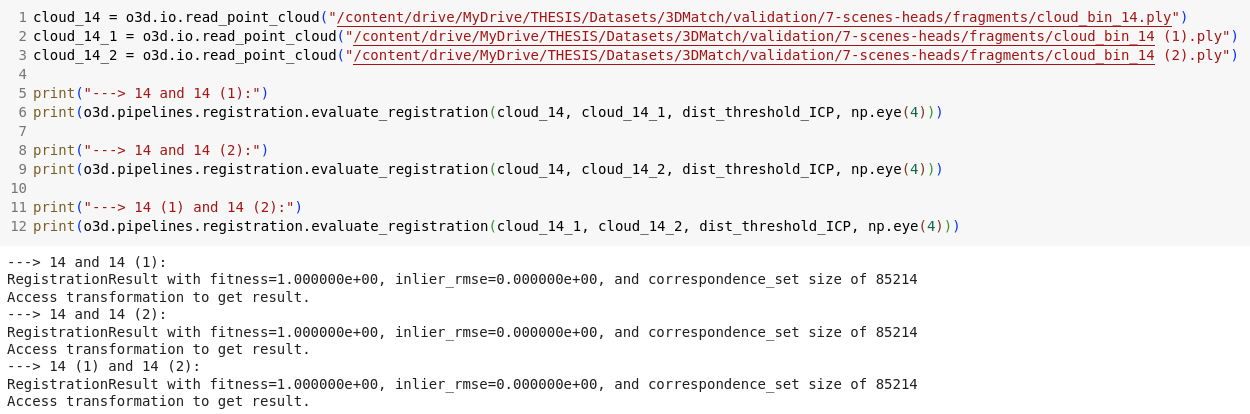

Since the fitness is 100% and the inlier RMSE is 0, we conclude that all clouds are the same, so it is ok to consider only one of them as was done during this implementation.